In [1]:
import numpy as np # linear algebra library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile # to read zip files
import csv
from sklearn.model_selection import train_test_split


# data understanding libraries
import matplotlib.pyplot as plt # ploting library
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter


# data preparation
import re
from nltk.stem import PorterStemmer


# ADS Creation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB

# Evaluation and Model Selection
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

Import data********

In [2]:
train=pd.read_csv('../input/moviesdataset/train.csv')
train.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1.0
1,2,1,A series of escapades demonstrating the adage ...,2.0
2,3,1,A series,2.0
3,4,1,A,2.0
4,5,1,series,2.0


Data Understanding********

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PhraseId    156060 non-null  int64  
 1   SentenceId  156060 non-null  int64  
 2   Phrase      156060 non-null  object 
 3   Sentiment   156059 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.8+ MB


In [4]:
train_data, test_data = train_test_split(train, test_size=0.4, random_state=1)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=1)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print("Train set size is ",len(train_data))
print("Val set size is ",len(val_data))
print("Test set size is ",len(test_data))

Train set size is  93636
Val set size is  31212
Test set size is  31212


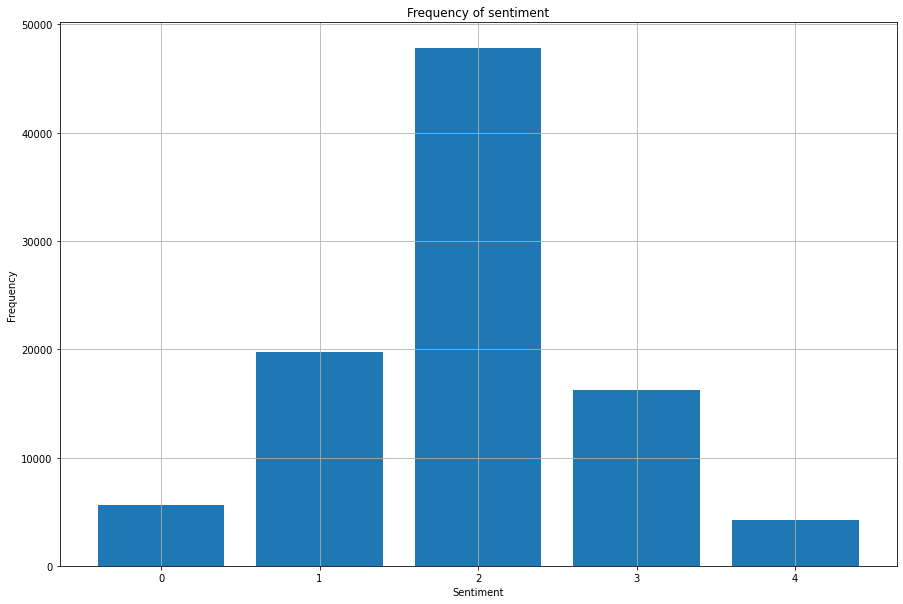

In [5]:
labels = train_data['Sentiment'].unique()
# plot the graph
fig, ax = plt.subplots(figsize=(15,10)) # create the plot and specify the figure size
plt.xlabel('Sentiment') # specify the x labels
plt.ylabel('Frequency') # specify the y labels
plt.title('Frequency of sentiment') # specify the plot title
plt.bar(labels,train_data['Sentiment'].value_counts()) # create a bar plot
plt.xticks(rotation=0) # rotate the x labels
plt.grid() # show the grid
plt.show() # show the final plot

Data preparation********

In [6]:
stopwords = set(["is","the","at","a","#NAME?","what","Aug","Sep","Chinese","Irish"])

In [7]:
porter=PorterStemmer()
def ret_words(Phrase):
    phrase = ' '.join(Phrase)
    phrase=Phrase.lower()
    phrase=phrase.replace("/"," ")
    phrase=phrase.replace("?"," ")
    phrase=phrase.replace(","," ")
    phrase=phrase.replace("--"," ")
    phrase=phrase.replace("."," ")
    phrase=phrase.replace("!"," ")
    phrase=phrase.replace(":"," ")
    phrase=phrase.replace(";"," ")
    phrase=phrase.replace("-"," ")
    phrase=phrase.replace("$"," ")
    phrase=phrase.replace("&"," ")
    phrase=phrase.replace("%"," ")
    phrase=phrase.replace("#"," ")
    phrase=phrase.replace("#"," ")
    phrase=phrase.replace("''", "")
    phrase=phrase.replace("`","")
    phrase=phrase.replace("""""","")
    phrase=phrase.replace("'","")
   
    words=[]
    for word in phrase.split():
        if re.findall('[0-9]', word): continue
        if len(word) <= 3: continue
        if word in stopwords: continue
        if re.findall('[^a-zA-Z]',re.sub(r'[^\w\s]','',word)): continue
        if len(word) > 0: words.append(porter.stem(re.sub(r'[^\w\s]','',word)))


return ' '.join(words)


SyntaxError: 'return' outside function (<ipython-input-7-038146c6d200>, line 33)

In [8]:
train_data = train_data.drop(train_data.index[64])
train_data = train_data.drop(train_data.index[0])
train_data['txt'] = train_data['Phrase'].apply(ret_words)
test_data['txt'] = test_data['Phrase'].apply(ret_words)
val_data['txt'] = val_data['Phrase'].apply(ret_words)
train_data=train_data.drop(['SentenceId'], axis = 1)
test_data=test_data.drop(['SentenceId'], axis = 1)
val_data=val_data.drop(['SentenceId'], axis = 1)
train_data.head(65)    


,PhraseId,Phrase,Sentiment,txt
1,15525,trying to go,2.0,None
2,119919,a week to live,2.0,None
3,17938,Essentially a collection of bits,2.0,None
4,98852,"The director , with his fake backdrops and sta...",1.0,None
5,33703,'ll regret,2.0,None
...,...,...,...,...
61,54172,purely abstract terms,2.0,None
62,119504,"is Garcia , who perfectly portrays the despera...",2.0,None
63,2830,those wisecracking Mystery Science Theater 300...,2.0,None
65,28896,shocking lack,1.0,None


In [9]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 93634 entries, 1 to 93635
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PhraseId   93634 non-null  int64  
 1   Phrase     93634 non-null  object 
 2   Sentiment  93634 non-null  float64
 3   txt        0 non-null      object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.6+ MB


In [10]:
len( train_data['txt'].unique())
    

1

In [11]:
id_train, X_train, y_train = train_data['PhraseId'], train_data['txt'], train_data['Sentiment']
id_test, X_test, y_test = test_data['PhraseId'], test_data['txt'], test_data['Sentiment']
id_val, X_val, y_val = val_data['PhraseId'], val_data['txt'], val_data['Sentiment']

Modeling********

In [12]:
LR_clf_counts = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(random_state=0, max_iter=2000))
])
LR_clf_counts.fit(X_train, y_train)
LR_cnt_pred_tr = LR_clf_counts.predict(X_train)

print(accuracy_score(y_train, LR_cnt_pred_tr))
print(precision_score(y_train, LR_cnt_pred_tr, average='weighted'))

AttributeError: 'NoneType' object has no attribute 'lower'

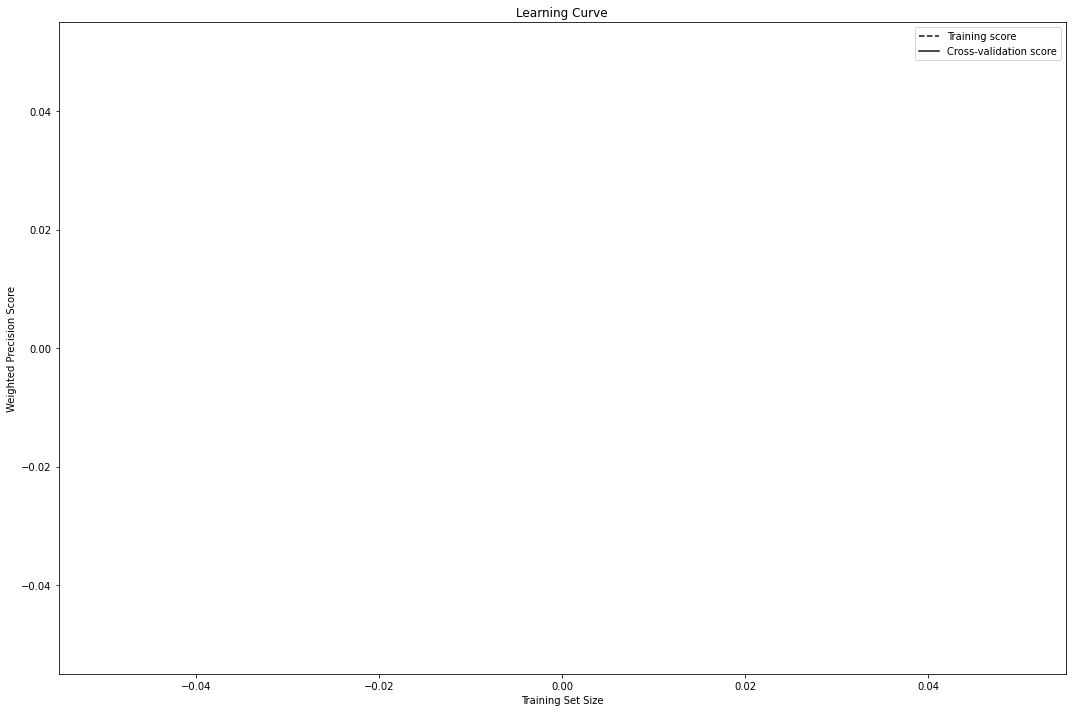

In [13]:
train_sizes, train_scores, test_scores = learning_curve(LR_clf_counts, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='precision_weighted',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [14]:
SVM_clf_counts = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LinearSVC( max_iter=2000))
])
SVM_clf_counts.fit(X_train, y_train)
SVM_cnt_pred_tr = SVM_clf_counts.predict(X_train)

print(accuracy_score(y_train, SVM_cnt_pred_tr))
print(precision_score(y_train, SVM_cnt_pred_tr, average='weighted'))

AttributeError: 'NoneType' object has no attribute 'lower'

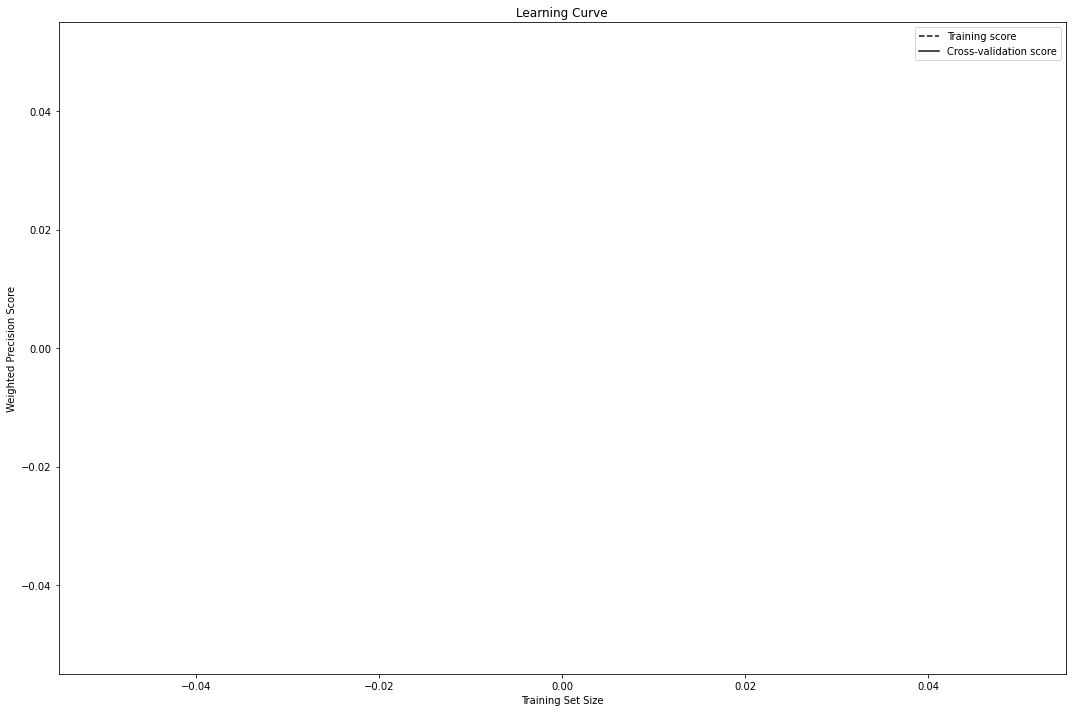

In [15]:
train_sizes, train_scores, test_scores = learning_curve(SVM_clf_counts, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='precision_weighted',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [16]:
NB_clf_counts = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])
NB_clf_counts.fit(X_train, y_train)
NB_cnt_pred_tr = NB_clf_counts.predict(X_train)

print(accuracy_score(y_train, NB_cnt_pred_tr))
print(precision_score(y_train, NB_cnt_pred_tr, average='weighted'))




AttributeError: 'NoneType' object has no attribute 'lower'

In [17]:
LR_clf_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.25, norm='l2', encoding='latin-1',ngram_range=(1, 2), stop_words='english')),
    ('clf', LogisticRegression(random_state=0, max_iter=2000))
])
LR_clf_tfidf.fit(X_train, y_train)
LR_tfidf_pred_tr = LR_clf_tfidf.predict(X_train)

print(accuracy_score(y_train, LR_tfidf_pred_tr))
print(precision_score(y_train, LR_tfidf_pred_tr, average='weighted'))

AttributeError: 'NoneType' object has no attribute 'lower'

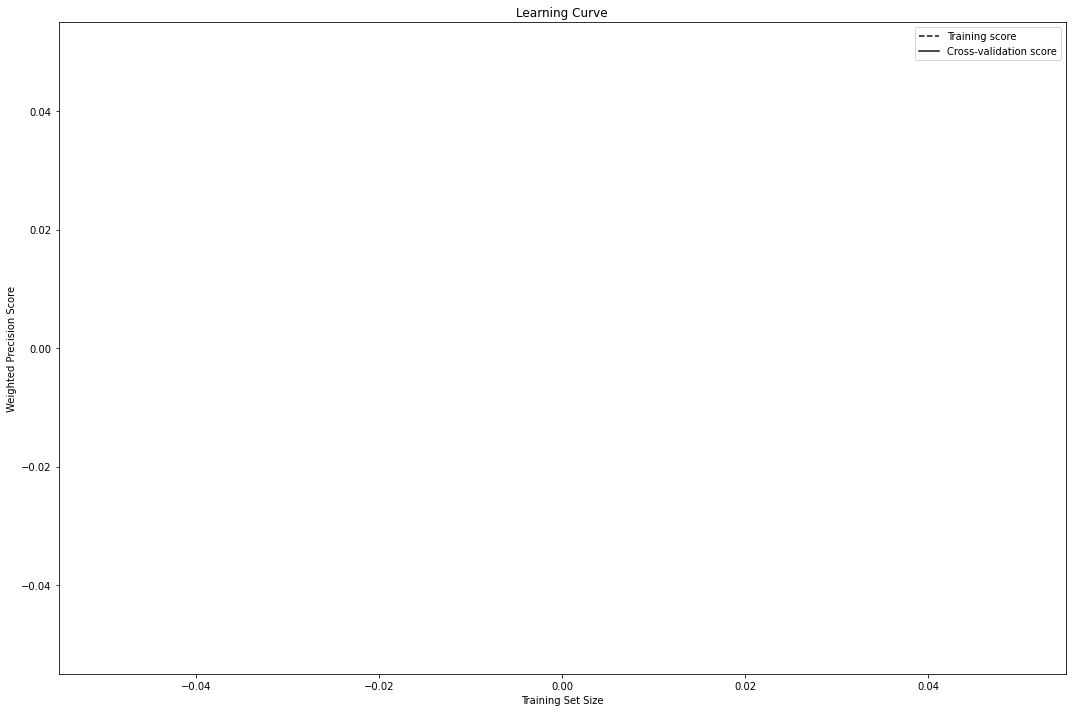

In [18]:
train_sizes, train_scores, test_scores = learning_curve(LR_clf_tfidf, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='precision_weighted',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [19]:
SVM_clf_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.25, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),
    ('clf', LinearSVC( max_iter=2000))
])
SVM_clf_tfidf.fit(X_train, y_train)
SVM_tfidf_pred_tr = SVM_clf_tfidf.predict(X_train)

print(accuracy_score(y_train, SVM_tfidf_pred_tr))
print(precision_score(y_train, SVM_tfidf_pred_tr, average='weighted'))

AttributeError: 'NoneType' object has no attribute 'lower'

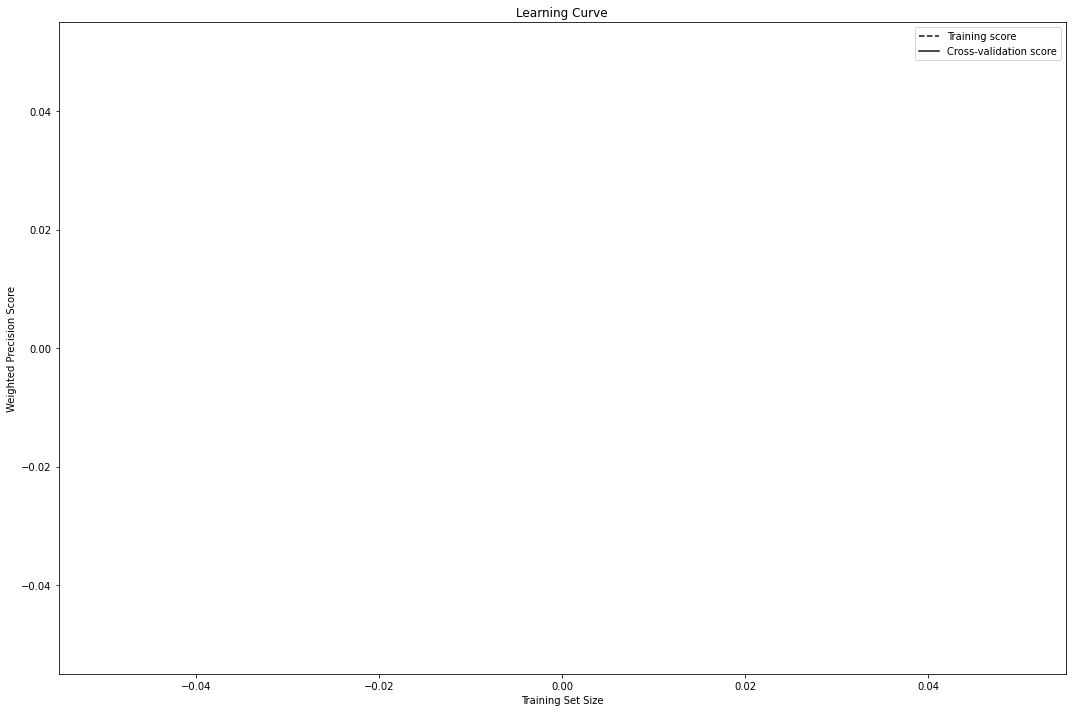

In [20]:
train_sizes, train_scores, test_scores = learning_curve(SVM_clf_tfidf, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='precision_weighted',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [21]:
NB_clf_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.25, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),
    ('clf', MultinomialNB())
])
NB_clf_tfidf.fit(X_train, y_train)
NB_tfidf_pred_tr = NB_clf_tfidf.predict(X_train)

print(accuracy_score(y_train, NB_tfidf_pred_tr))
print(precision_score(y_train, NB_tfidf_pred_tr, average='weighted'))

AttributeError: 'NoneType' object has no attribute 'lower'

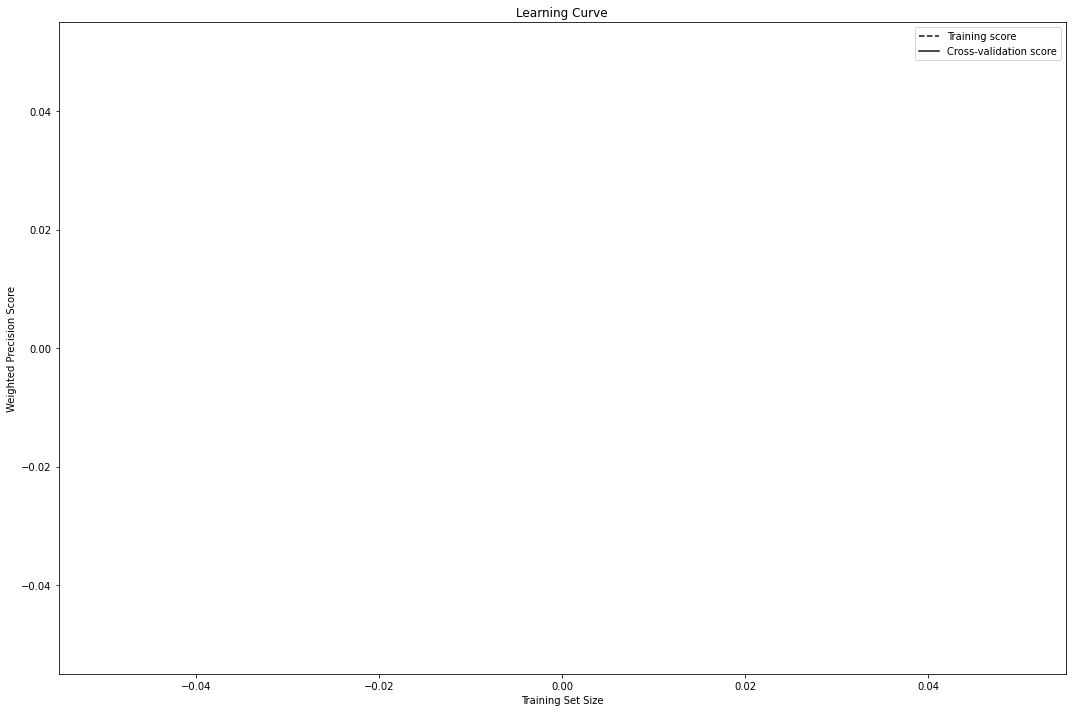

In [22]:
train_sizes, train_scores, test_scores = learning_curve(NB_clf_tfidf, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='precision_weighted',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Hyperparameter tuning********

Final Model********